## Project 1: Predict the Housing Prices in Ames

#### [1. Introduction](#1)
##### [1.1. Input Data](#1.1)
#### [2. EDA](#)
#### [3. Results](#)

#### [x. References](#)
#### [x. Data Dictionary](#data_dict)

## <a id = '1'>1. Introduction<a/>

- The goal of this project is to predict the final price of a home (in log scale) using Ames housing dataset availalble on <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques">Kaggle</a>. This is primarily a regression problem.

- Two models will be built:
    1. using linear regression with Lasso or Ridge or Elasticnet penalty
    2. using tree based models such as random forest or boosting tree.

### <a id='1.1'> 1.1 Input Data<a/>

- There are 83 columns and 2930 row objects. Explaination of each column can be found in the [Data Dictionary](#data_dict).
    

In [42]:
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from scipy.stats import norm, skew
from scipy.stats import shapiro
import pylab
from scipy.stats.mstats import winsorize

In [43]:
ames_data = pd.read_csv('Ames_data.csv')
ames_data.head()

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude,Sale_Price
0,526301100,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Fence,None,0,5,2010,WD,Normal,-93.619754,42.054035,215000
1,526350040,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,Minimum_Privacy,None,0,6,2010,WD,Normal,-93.619756,42.053014,105000
2,526351010,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Fence,Gar2,12500,6,2010,WD,Normal,-93.619387,42.052659,172000
3,526353030,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,No_Fence,None,0,4,2010,WD,Normal,-93.617320,42.051245,244000
4,527105010,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,Minimum_Privacy,None,0,3,2010,WD,Normal,-93.638933,42.060899,189900


In [44]:
len(ames_data)

2930

### <a id='1.2'> 1.2 Test Ids<a/>
    
- There are 10 different test id list, each containing 879 objects

In [45]:
dat_file = 'project1_testIDs.dat'
test_ids = np.loadtxt(dat_file).T
test_ids.shape

(10, 879)

### <a id='1.3'> 1.3 Evaluation Metric<a/>
    
- To measure the performance of the regression models, root mean squared log error is used as a performance metric.

> $$ \sqrt{\frac{1}{\text{n.test}} \sum_{j=1}^{\text{n.test}} (\log(\hat{y}_j) - \log(y_j))^2}$$

## <a id = '1'>2. Data pre-processing<a/>

Taking a look at the data structure of input data.

In [46]:
def get_df_info(input_of):
    df_info = pd.DataFrame(columns=['column', 'Null Count', 'Data Type'])
    for col in input_of:
        Null_count  = sum(pd.isnull(input_of[col]))
        dtype = input_of[col].dtype
        df_info = df_info.append({'column': col, 'Null Count': Null_count, 'Data Type': dtype},
                                ignore_index = True)
    
    return df_info

df_info = get_df_info(ames_data)

In [47]:
df_info.head() # same as df.info()

,column,Null Count,Data Type
0,PID,0,int64
1,MS_SubClass,0,object
2,MS_Zoning,0,object
3,Lot_Frontage,0,int64
4,Lot_Area,0,int64


In [48]:
df_info.groupby(['Data Type']).count()

,column,Null Count
Data Type,,
int64,34,34
float64,3,3
object,46,46


In [49]:
# ames_data.info()

There are 159 empty values for Garage_Yr_Blt. For now, we will keep them as it is.

In [50]:
ames_data.describe()

,PID,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,...,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Year_Sold,Longitude,Latitude,Sale_Price
count,2.930000e+03,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,7.144645e+08,57.647782,10147.921843,1971.356314,1984.266553,101.096928,4.177474,49.705461,559.071672,1051.255631,...,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,-93.642897,42.034482,180796.060068
std,1.887308e+08,33.499441,7880.017759,30.245361,20.860286,178.634545,2.233372,169.142089,439.540571,440.968018,...,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,0.025700,0.018410,79886.692357
min,5.263011e+08,0.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,-93.693153,41.986498,12789.000000
25%,5.284770e+08,43.000000,7440.250000,1954.000000,1965.000000,0.000000,3.000000,0.000000,219.000000,793.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,-93.660217,42.022088,129500.000000
50%,5.354536e+08,63.000000,9436.500000,1973.000000,1993.000000,0.000000,3.000000,0.000000,465.500000,990.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,-93.641806,42.034662,160000.000000
75%,9.071811e+08,78.000000,11555.250000,2001.000000,2004.000000,162.750000,7.000000,0.000000,801.750000,1301.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,-93.622113,42.049853,213500.000000
max,1.007100e+09,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,7.000000,1526.000000,2336.000000,6110.000000,...,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,-93.577427,42.063388,755000.000000


winsorize 3 outliers in Gr_Liv_Area

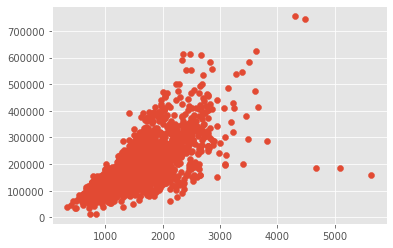

In [51]:
plt.scatter(ames_data.Gr_Liv_Area, ames_data.Sale_Price)
plt.show()

In [52]:
ames_data[ames_data.Gr_Liv_Area >  4500].index

Int64Index([1498, 2180, 2181], dtype='int64')

In [53]:
outliers_a = ames_data.Gr_Liv_Area[(ames_data.Gr_Liv_Area > np.mean(ames_data.Gr_Liv_Area) + 3*np.std(ames_data.Gr_Liv_Area))].count()
outliers_b = ames_data.Gr_Liv_Area[(ames_data.Gr_Liv_Area < np.mean(ames_data.Gr_Liv_Area) - 3*np.std(ames_data.Gr_Liv_Area))].count()
outliers_a, outliers_b

(25, 0)

winsorize outliers based on Gr_Liv_Area variable.

In [54]:
winsz_Gr_Liv_Area = winsorize(ames_data.Gr_Liv_Area, limits=[0.05, 0.05])

In [55]:
ames_data['Gr_Liv_Area'] = winsz_Gr_Liv_Area

winsorize outliers based on our target variable.

In [56]:
outliers_a = ames_data.Sale_Price[(ames_data.Sale_Price > np.mean(ames_data.Sale_Price) + 3*np.std(ames_data.Sale_Price))].count()
outliers_b = ames_data.Sale_Price[(ames_data.Sale_Price < np.mean(ames_data.Sale_Price) - 3*np.std(ames_data.Sale_Price))].count()
outliers_a, outliers_b

(45, 0)

> * There are 45 objects (data points) which have thier values above 3 standard deviations from mean. Lets winsorize them.

In [57]:
# winsz_sale_price = winsorize(ames_data.Sale_Price, limits=[0.05, 0.05])
# ames_data['Sale_Price'] = winsz_sale_price

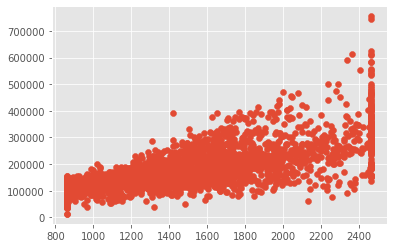

In [58]:
plt.scatter(ames_data.Gr_Liv_Area, ames_data.Sale_Price)
plt.show()

In [59]:
# We can drop PID since this won't affect Sale_Price
ames_data.drop(['PID'], axis=1, inplace=True)

### Convert Year values to age

In [60]:
ames_data[['Year_Remod_Add', 'Year_Built', 'Mo_Sold', 'Year_Sold']]

,Year_Remod_Add,Year_Built,Mo_Sold,Year_Sold
0,1960,1960,5,2010
1,1961,1961,6,2010
2,1958,1958,6,2010
3,1968,1968,4,2010
4,1998,1997,3,2010
...,...,...,...,...
2925,1984,1984,3,2006
2926,1983,1983,6,2006
2927,1992,1992,7,2006
2928,1975,1974,4,2006


In [61]:
ames_data[['Year_Remod_Add', 'Year_Built', 'Mo_Sold', 'Year_Sold']].describe()

,Year_Remod_Add,Year_Built,Mo_Sold,Year_Sold
count,2930.000000,2930.000000,2930.000000,2930.000000
mean,1984.266553,1971.356314,6.216041,2007.790444
std,20.860286,30.245361,2.714492,1.316613
min,1950.000000,1872.000000,1.000000,2006.000000
25%,1965.000000,1954.000000,4.000000,2007.000000
50%,1993.000000,1973.000000,6.000000,2008.000000
75%,2004.000000,2001.000000,8.000000,2009.000000
max,2010.000000,2010.000000,12.000000,2010.000000


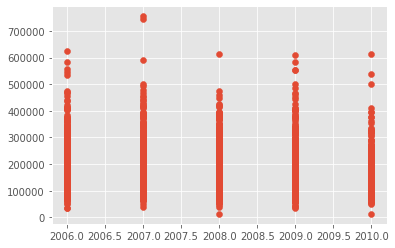

In [62]:
plt.style.use('ggplot')
plt.scatter(x = ames_data.Year_Sold, y = ames_data.Sale_Price)
plt.show()

In [63]:
yrBuilt = ames_data.groupby(['Year_Built']).mean()['Sale_Price']
yrRemod = ames_data.groupby(['Year_Remod_Add']).mean()['Sale_Price']

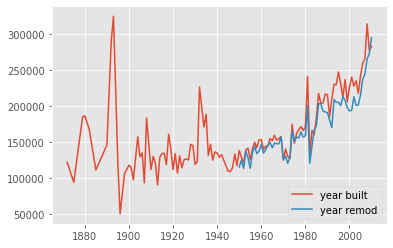

In [64]:
plt.plot(yrBuilt, label = 'year built')
plt.plot(yrRemod, label = 'year remod')
plt.legend()
plt.show()

>    - We can see that year sold does not have any correlation with sale price, hence lets drop it.

>    - We can also see year built and year remod have same mean sale price. Hence let's drop year remod and replace year built by age of the property.

In [65]:
ames_data.drop(['Year_Remod_Add', 'Mo_Sold', 'Year_Sold'], axis=1, inplace=True)
ames_data['Age_of_Property'] = 2010 - ames_data['Year_Built']
ames_data.drop(['Year_Built'], axis=1, inplace=True)

## <a id = '3'>3. EDA<a/>

### <a id='1.1'> 3.1 Categorical Variables Selection<a/>

In [66]:
df_info = get_df_info(ames_data)
categorical_vars = df_info[df_info['Data Type'] == 'object']
categorical_vars['Number of Categories'] = [len(ames_data[col].value_counts()) for col in categorical_vars.column]

In [67]:
len(categorical_vars)

46

In [68]:
categorical_vars

,column,Null Count,Data Type,Number of Categories
0,MS_SubClass,0,object,16
1,MS_Zoning,0,object,7
4,Street,0,object,2
5,Alley,0,object,3
6,Lot_Shape,0,object,4
7,Land_Contour,0,object,4
8,Utilities,0,object,3
9,Lot_Config,0,object,5
10,Land_Slope,0,object,3
11,Neighborhood,0,object,28


Lets visualize features that have less than 10 categories

In [69]:
cols = categorical_vars

In [70]:
import plotly.express as px
figures = []
for col in categorical_vars.column:
    fig = px.box(ames_data, x=col, y="Sale_Price", points="all", color = col)
    figures.append(fig)

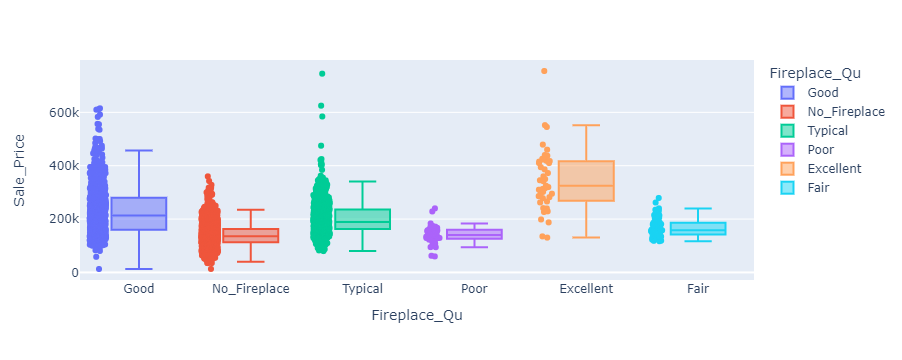

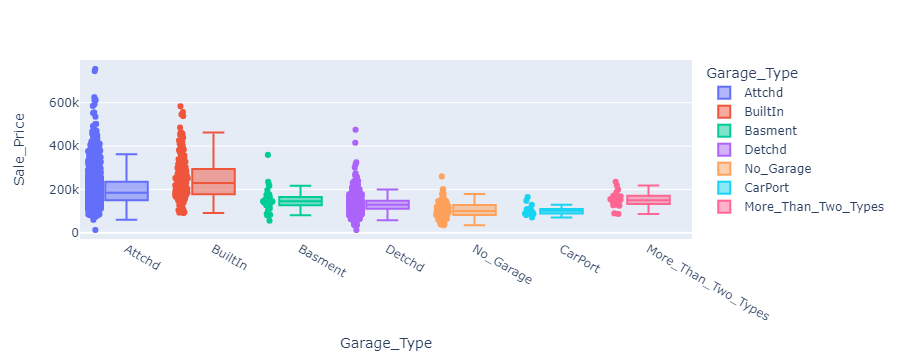

In [71]:
for fig in figures[35:37]:
    fig.show()

By looking at the boxplots, below categorical variable seem to provide variation that matches with sales price. Five stars provide max variance.

- Sale_Type *****
- Sale_Condition ****
- Paved_Drive ****
- Garage_Finish ****
- Garage_Type ****
- Fireplace_Qu ****
- Kitchen_Qual *****
- Central_Air *****
- Heating_QC ****
- Electrical ***
- Bsmt_Exposure ****
- Bsmt_Qual *****
- Foundation ***
- Exter_Qual *****
- Overall_Qual *****
- Condition_1 ***
- Neighborhood ****
- MS_Zoning ****
- MS_SubClass ***

In [72]:
# fig = px.box(ames_data, x="Sale_Type", y="Sale_Price")
# fig.show()

In [73]:
# Selected Categorical Variables: 
selected_cat_col = ['Sale_Type', 'Fireplace_Qu', 'Kitchen_Qual', 'Central_Air', 'Heating_QC', 'Bsmt_Exposure', 
 'Bsmt_Qual', 'Exter_Qual', 'Overall_Qual', 'Neighborhood', 'MS_Zoning', 'Garage_Type', 'Sale_Condition', 
 'Paved_Drive', 'Garage_Finish', 'MS_SubClass', 'Electrical','Foundation', 'condition_1']

### <a id='1.1'> 3.1 Numerical Variables Selection<a/>

In [74]:
num_vars = df_info[df_info['Data Type'] != 'object']
num_vars

,column,Null Count,Data Type
2,Lot_Frontage,0,int64
3,Lot_Area,0,int64
23,Mas_Vnr_Area,0,int64
31,BsmtFin_SF_1,0,int64
33,BsmtFin_SF_2,0,int64
34,Bsmt_Unf_SF,0,int64
35,Total_Bsmt_SF,0,int64
40,First_Flr_SF,0,int64
41,Second_Flr_SF,0,int64
42,Low_Qual_Fin_SF,0,int64


- We can eleminate variables using co-relation plot
> $$Corr(x, y) = {\displaystyle \rho _{X,Y}=\operatorname {corr} (X,Y)={\operatorname {cov} (X,Y) \over \sigma _{X}\sigma _{Y}}={\operatorname {E} [(X-\mu _{X})(Y-\mu _{Y})] \over \sigma _{X}\sigma _{Y}}}$$

Alternatively,
$$ Corr(x,y) = {\displaystyle \rho _{X,Y}={\operatorname {E} (XY)-\operatorname {E} (X)\operatorname {E} (Y) \over {\sqrt {\operatorname {E} (X^{2})-\operatorname {E} (X)^{2}}}\cdot {\sqrt {\operatorname {E} (Y^{2})-\operatorname {E} (Y)^{2}}}}}$$


Sample correlation coefficient(r) $$ r = {\frac {\sum \limits _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{\sqrt {\sum \limits _{i=1}^{n}(x_{i}-{\bar {x}})^{2}\sum \limits _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}} $$


In [75]:
ames_data.columns

Index(['MS_SubClass', 'MS_Zoning', 'Lot_Frontage', 'Lot_Area', 'Street',
       'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities', 'Lot_Config',
       'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
       'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style',
       'Roof_Matl', 'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type',
       'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
       'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_SF_1',
       'BsmtFin_Type_2', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF',
       'Heating', 'Heating_QC', 'Central_Air', 'Electrical', 'First_Flr_SF',
       'Second_Flr_SF', 'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',
       'Garage_Finish', 'Garage_Cars', 'Garage_Area', 'G

In [76]:
ames_num_cols_df = ames_data.loc[:, ames_data.columns.isin(num_vars.column.tolist())]

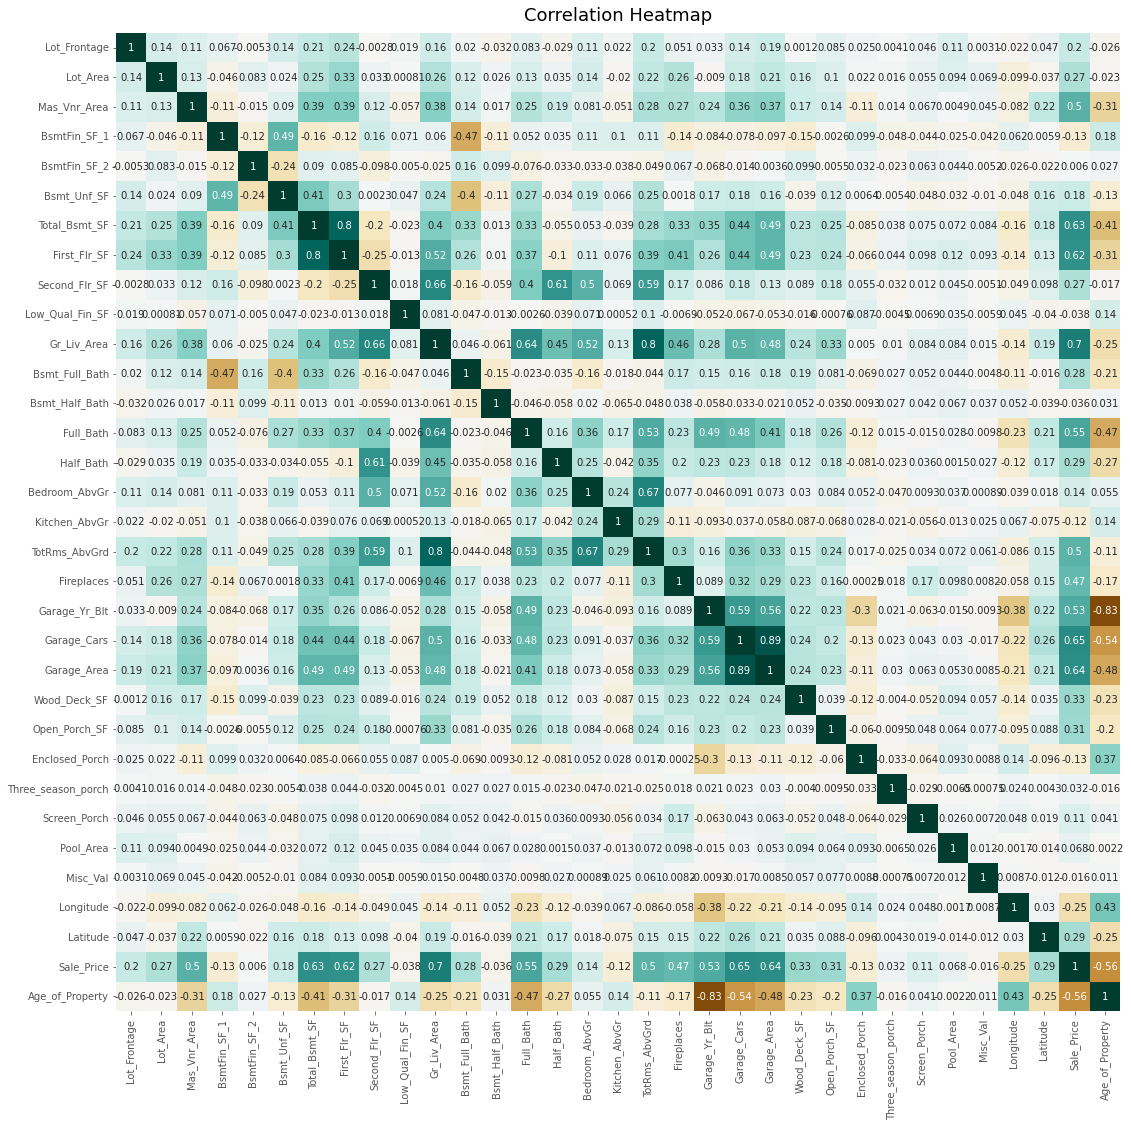

In [77]:
plt.figure(figsize=(18, 18))
heatmap = sns.heatmap(ames_num_cols_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', cbar=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('correlationPlot.png', dpi=1000)

- Below columns can be removed which have either high correlation with one of the predictor or little to no correlation with target variable
    - Garage_Yr_Blt (has high correlation with year built)
    - 'Lot_Fontage', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unit_SF', 'Second_Flr_SF', 'Bsmt_Half_Bath', 'Half_Bath', 'Bedroom_AbvGrd', 'Enclosed_Porch', 'Three_season_porch', 'Screen_Porch', 'Pool_Area', 'Misc_Val', 'Mo_Sold', 'Year_Sold'

In [78]:
corr_df = ames_num_cols_df.corr()
corr_df_shortlisted = corr_df.loc[(corr_df['Sale_Price'] > 0.3) | (corr_df['Sale_Price'] < -0.3),:]
corr_df_shortlisted = corr_df_shortlisted.loc[:, corr_df_shortlisted.columns.isin(corr_df_shortlisted.index)]
corr_df_shortlisted = corr_df_shortlisted.loc[~corr_df_shortlisted.index.isin(['Garage_Yr_Blt']), ~corr_df_shortlisted.columns.isin(['Garage_Yr_Blt'])]
corr_df_shortlisted

,Mas_Vnr_Area,Total_Bsmt_SF,First_Flr_SF,Gr_Liv_Area,Full_Bath,TotRms_AbvGrd,Fireplaces,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,Sale_Price,Age_of_Property
Mas_Vnr_Area,1.000000,0.393530,0.392280,0.376712,0.254471,0.278418,0.270051,0.356831,0.370479,0.165875,0.140003,0.502196,-0.306797
Total_Bsmt_SF,0.393530,1.000000,0.800429,0.404221,0.325434,0.281627,0.333467,0.437856,0.485608,0.230290,0.245941,0.632529,-0.407764
First_Flr_SF,0.392280,0.800429,1.000000,0.518902,0.371584,0.390162,0.406345,0.439471,0.491208,0.227131,0.238041,0.621676,-0.310463
Gr_Liv_Area,0.376712,0.404221,0.518902,1.000000,0.642371,0.804568,0.456165,0.498018,0.477219,0.236509,0.327756,0.702279,-0.253161
Full_Bath,0.254471,0.325434,0.371584,0.642371,1.000000,0.528599,0.229793,0.477070,0.406497,0.179574,0.258675,0.545604,-0.469406
TotRms_AbvGrd,0.278418,0.281627,0.390162,0.804568,0.528599,1.000000,0.302865,0.355448,0.327217,0.154735,0.235684,0.495474,-0.111919
Fireplaces,0.270051,0.333467,0.406345,0.456165,0.229793,0.302865,1.000000,0.321597,0.294262,0.228064,0.159637,0.474558,-0.170672
Garage_Cars,0.356831,0.437856,0.439471,0.498018,0.477070,0.355448,0.321597,1.000000,0.889866,0.240484,0.204535,0.647562,-0.537982
Garage_Area,0.370479,0.485608,0.491208,0.477219,0.406497,0.327217,0.294262,0.889866,1.000000,0.237682,0.233229,0.640138,-0.480726
Wood_Deck_SF,0.165875,0.230290,0.227131,0.236509,0.179574,0.154735,0.228064,0.240484,0.237682,1.000000,0.039243,0.327143,-0.228964


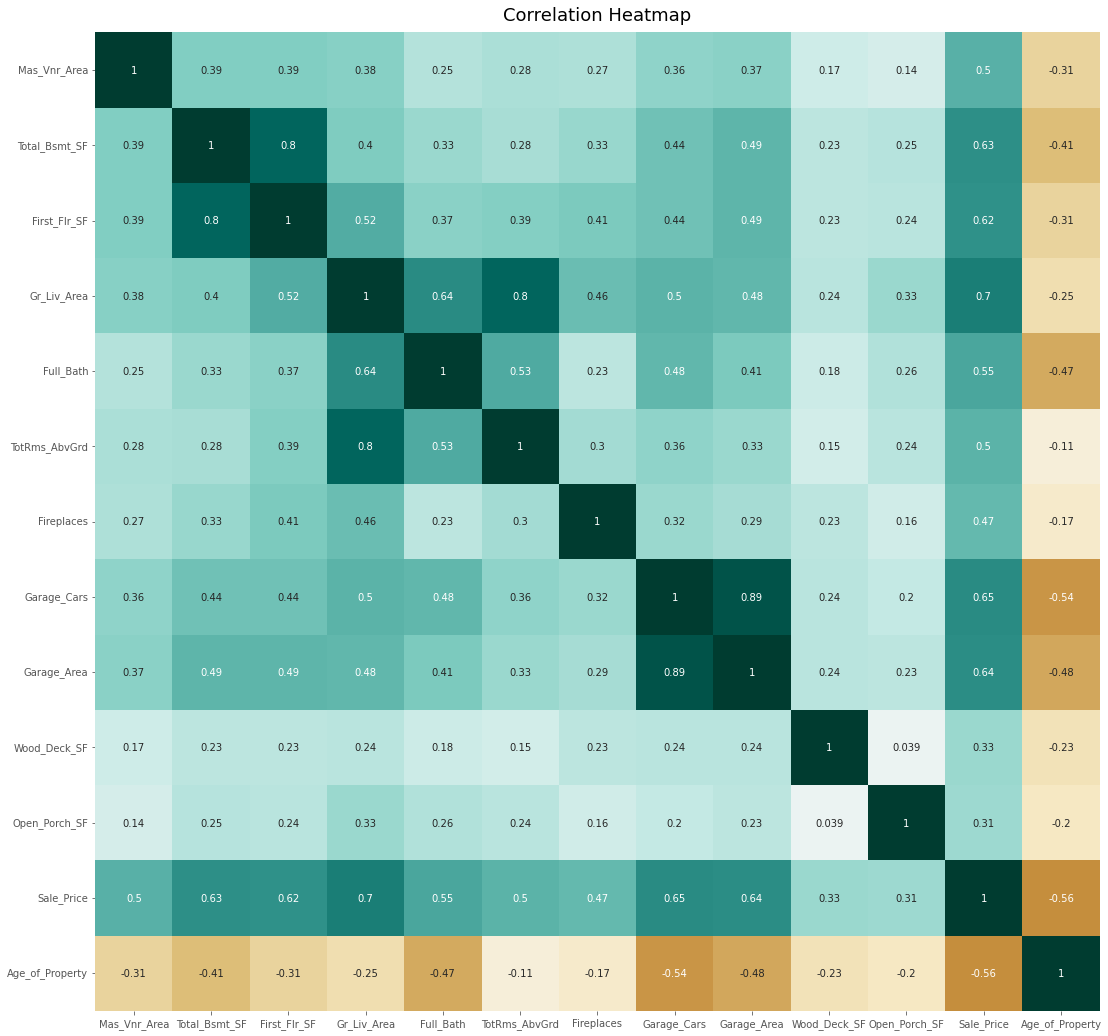

In [79]:
plt.figure(figsize=(18, 18))
heatmap = sns.heatmap(corr_df_shortlisted, vmin=-1, vmax=1, annot=True, cmap='BrBG', cbar=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('correlationPlot_final.png', dpi=1000)

Further we can remove below variables that are highly correlated with each other.
1. Garage_Area (r = 0.9 with Garage_Cars)
2. TotRms_AbvGrd (r = 0.8 with Gr_Liv_Area)
3. First_Flr_SF (r = 0.8 with Total_Bsmt_SF)

In [80]:
corr_df_shortlisted = corr_df_shortlisted.loc[~corr_df_shortlisted.index.isin(['Garage_Area', 'First_Flr_SF']), ~corr_df_shortlisted.columns.isin(['Garage_Area', 'First_Flr_SF'])]

In [81]:
corr_df_shortlisted

,Mas_Vnr_Area,Total_Bsmt_SF,Gr_Liv_Area,Full_Bath,TotRms_AbvGrd,Fireplaces,Garage_Cars,Wood_Deck_SF,Open_Porch_SF,Sale_Price,Age_of_Property
Mas_Vnr_Area,1.000000,0.393530,0.376712,0.254471,0.278418,0.270051,0.356831,0.165875,0.140003,0.502196,-0.306797
Total_Bsmt_SF,0.393530,1.000000,0.404221,0.325434,0.281627,0.333467,0.437856,0.230290,0.245941,0.632529,-0.407764
Gr_Liv_Area,0.376712,0.404221,1.000000,0.642371,0.804568,0.456165,0.498018,0.236509,0.327756,0.702279,-0.253161
Full_Bath,0.254471,0.325434,0.642371,1.000000,0.528599,0.229793,0.477070,0.179574,0.258675,0.545604,-0.469406
TotRms_AbvGrd,0.278418,0.281627,0.804568,0.528599,1.000000,0.302865,0.355448,0.154735,0.235684,0.495474,-0.111919
Fireplaces,0.270051,0.333467,0.456165,0.229793,0.302865,1.000000,0.321597,0.228064,0.159637,0.474558,-0.170672
Garage_Cars,0.356831,0.437856,0.498018,0.477070,0.355448,0.321597,1.000000,0.240484,0.204535,0.647562,-0.537982
Wood_Deck_SF,0.165875,0.230290,0.236509,0.179574,0.154735,0.228064,0.240484,1.000000,0.039243,0.327143,-0.228964
Open_Porch_SF,0.140003,0.245941,0.327756,0.258675,0.235684,0.159637,0.204535,0.039243,1.000000,0.312951,-0.198365
Sale_Price,0.502196,0.632529,0.702279,0.545604,0.495474,0.474558,0.647562,0.327143,0.312951,1.000000,-0.558426


Visualizing Lattitude and Longitude and sales price

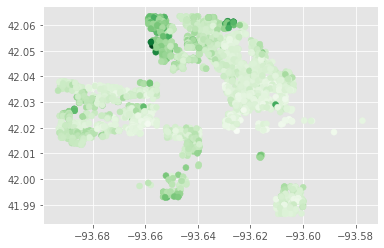

In [82]:
plt.scatter(ames_data.Longitude, ames_data.Latitude, c=ames_data.Sale_Price, cmap='Greens')
plt.show()

- We can see that there are some spots where prices are high, for most part, price is constant.

## <a id="#">3. Modeling</a>

In [83]:
selected_cat_col.extend(corr_df_shortlisted.columns)

In [84]:
ames_final = ames_data.loc[:, ames_data.columns.isin(selected_cat_col)]
ames_final = ames_data
ames_final.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Sale_Type,Sale_Condition,Longitude,Latitude,Sale_Price,Age_of_Property
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,WD,Normal,-93.619754,42.054035,215000,50
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,WD,Normal,-93.619756,42.053014,105000,49
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,Gar2,12500,WD,Normal,-93.619387,42.052659,172000,52
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,WD,Normal,-93.617320,42.051245,244000,42
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,WD,Normal,-93.638933,42.060899,189900,13


### <a id='3.3'> 3.2 XgBoost<a/>

In [85]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
X = ames_final.loc[:, ~ames_final.columns.str.contains('Sale_Price')]
y = ames_final['Sale_Price']

In [86]:
for col in ames_final.columns:
    if ames_final[col].dtype == 'object':
        X[col] = lbl.fit_transform(X[col].astype(str))

In [87]:
ames_final.iloc[test_ids[0],:]

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Sale_Type,Sale_Condition,Longitude,Latitude,Sale_Price,Age_of_Property
902,One_and_Half_Story_Finished_All_Ages,Residential_Low_Density,67,12354,Pave,Gravel,Regular,Lvl,AllPub,Corner,...,No_Pool,Good_Privacy,Shed,800,ConLI,Normal,-93.657963,42.022092,110000,90
755,One_Story_1945_and_Older,Residential_Medium_Density,52,6240,Pave,Gravel,Regular,Lvl,AllPub,Inside,...,No_Pool,No_Fence,None,0,WD,Normal,-93.626716,42.023085,103000,85
1618,Two_Story_1946_and_Newer,Residential_Low_Density,57,8773,Pave,No_Alley_Access,Slightly_Irregular,HLS,AllPub,Inside,...,No_Pool,No_Fence,None,0,WD,Normal,-93.636972,42.061326,169000,13
166,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,7635,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,WD,Normal,-93.606742,42.034851,148000,50
1371,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,82,9488,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,No_Fence,None,0,WD,Abnorml,-93.658159,42.034391,124000,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,80,10400,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,No_Fence,None,0,WD,Normal,-93.635411,42.053271,192350,31
1496,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,60,7024,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,No_Fence,None,0,WD,Normal,-93.673251,42.018830,176000,5
1778,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,49,15256,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,No_Pool,No_Fence,None,0,WD,Normal,-93.641760,42.054177,282922,3
96,Two_Story_PUD_1946_and_Newer,Floating_Village_Residential,30,3182,Pave,Paved,Regular,Lvl,AllPub,Inside,...,No_Pool,No_Fence,None,0,WD,Normal,-93.644889,42.047899,151000,6


In [88]:
X_train = X.iloc[~X.index.isin(test_ids[0]),:]
X_test = X.iloc[X.index.isin(test_ids[0]),:]
y_train = ames_final.iloc[~ames_final.index.isin(test_ids[0]),:]['Sale_Price']
y_test = ames_final.iloc[ames_final.index.isin(test_ids[0]),:]['Sale_Price']

In [89]:
winsz_sale_price = winsorize(y_train, limits=[0.05, 0.05])
y_train = winsz_sale_price

In [90]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [91]:
# set parameters for model
param = {'max_depth': 50, 'eta': 0.1, 'objective': 'reg:squarederror'}
param['nthread'] = 4
param['eval_metric'] = 'rmsle'

In [92]:
# Specify validations set to watch performance
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [93]:
num_round = 20
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmsle:2.31946	train-rmsle:2.30973
[1]	eval-rmsle:1.67322	train-rmsle:1.66646
[2]	eval-rmsle:1.31869	train-rmsle:1.30977
[3]	eval-rmsle:1.08232	train-rmsle:1.07236
[4]	eval-rmsle:0.90936	train-rmsle:0.89870
[5]	eval-rmsle:0.77668	train-rmsle:0.76436
[6]	eval-rmsle:0.67159	train-rmsle:0.65740
[7]	eval-rmsle:0.58783	train-rmsle:0.57078
[8]	eval-rmsle:0.51803	train-rmsle:0.49857
[9]	eval-rmsle:0.46096	train-rmsle:0.43823
[10]	eval-rmsle:0.41283	train-rmsle:0.38660
[11]	eval-rmsle:0.37239	train-rmsle:0.34261
[12]	eval-rmsle:0.33881	train-rmsle:0.30466
[13]	eval-rmsle:0.30965	train-rmsle:0.27181
[14]	eval-rmsle:0.28551	train-rmsle:0.24319
[15]	eval-rmsle:0.26490	train-rmsle:0.21795
[16]	eval-rmsle:0.24674	train-rmsle:0.19589
[17]	eval-rmsle:0.23158	train-rmsle:0.17640
[18]	eval-rmsle:0.21862	train-rmsle:0.15921
[19]	eval-rmsle:0.20798	train-rmsle:0.14381


In [94]:
ypred = bst.predict(dtest)

In [95]:
def calc_rmsle(ypred, ytest):
#     return np.sqrt(np.mean((ypred - ytest)**2))
    return np.sqrt(np.mean((np.log(ypred) - np.log(ytest))**2))
calc_rmsle(ypred, y_test)

0.20798197430515228

### Hyperparameters tuning

In [96]:
# Create a list of hyperparameters
# ref: https://stackoverflow.com/questions/12130883/r-expand-grid-function-in-python
from itertools import product

def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

params = {
        'max_depth': [500],
        'eta': [0.1, 0.15, 0.2, 0.25],
        'min_child_weight': [5, 7],
        'gamma': [200, 2000, 10000],
        'subsample': [0.8],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'objective': ['reg:squarederror'],
        'reg_alpha':[50, 100]
        }
params_df = expand_grid(params)

In [97]:
print(len(params_df))
params_df.head()

144


,max_depth,eta,min_child_weight,gamma,subsample,colsample_bytree,objective,reg_alpha
0,500,0.1,5,200,0.8,0.6,reg:squarederror,50
1,500,0.1,5,200,0.8,0.6,reg:squarederror,100
2,500,0.1,5,200,0.8,0.8,reg:squarederror,50
3,500,0.1,5,200,0.8,0.8,reg:squarederror,100
4,500,0.1,5,200,0.8,1.0,reg:squarederror,50


In [98]:
# ames_final.drop(['Central_Air', 'Paved_Drive', 'Electrical', 'Full_Bath', 'Exter_Qual', 'Foundation', 'Sale_Type'], axis=1, inplace=True)

In [100]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
X = ames_final.loc[:, ~ames_final.columns.str.contains('Sale_Price')]
y = ames_final['Sale_Price']

In [101]:
for col in ames_final.columns:
    if ames_final[col].dtype == 'object':
        X[col] = lbl.fit_transform(X[col].astype(str))

In [102]:
X_train = X.iloc[~X.index.isin(test_ids[4]),:]
X_test = X.iloc[X.index.isin(test_ids[4]),:]
y_train = ames_final.iloc[~ames_final.index.isin(test_ids[4]),:]['Sale_Price']
y_test = ames_final.iloc[ames_final.index.isin(test_ids[4]),:]['Sale_Price']

In [103]:
winsz_sale_price = winsorize(y_train, limits=[0.05, 0.05])
y_train = winsz_sale_price
winsz_sale_price = winsorize(y_train, limits=[0.05, 0.05])
y_train = winsz_sale_price

In [104]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [105]:
rmsles = {}
for num in [60]:
    for idx in params_df.index:
        param = params_df.iloc[idx,:].to_dict()
        param['nthread'] = 4
        param['eval_metric'] = 'rmsle'
        evallist = [(dtest, 'eval'), (dtrain, 'train')]
        num_round = num
        bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)
        ypred = bst.predict(dtest)
        rmsle = calc_rmsle(ypred, y_test)
        rmsles.update({rmsle:param})

In [106]:
print(min(rmsles.keys()))
rmsles[min(rmsles.keys())]

0.15463078670819908


{'max_depth': 500,
 'eta': 0.15,
 'min_child_weight': 7,
 'gamma': 10000,
 'subsample': 0.8,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror',
 'reg_alpha': 100,
 'nthread': 4,
 'eval_metric': 'rmsle'}

In [499]:
print(min(rmsles.keys()))
rmsles[min(rmsles.keys())]

0.10513801271228435


{'max_depth': 500,
 'eta': 0.1,
 'min_child_weight': 5,
 'gamma': 10000,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'objective': 'reg:squarederror',
 'reg_alpha': 100,
 'nthread': 4,
 'eval_metric': 'rmsle'}

In [1382]:
print(min(rmsles.keys()))
rmsles[min(rmsles.keys())]

0.1396882759151403


{'max_depth': 500,
 'eta': 0.1,
 'min_child_weight': 5,
 'gamma': 2000,
 'subsample': 0.8,
 'colsample_bytree': 0.6,
 'objective': 'reg:squarederror',
 'reg_alpha': 50,
 'nthread': 4,
 'eval_metric': 'rmsle'}

## Cross-validation of the model with different test and train ids

In [736]:
param = rmsles[min(rmsles.keys())]
param['nthread'] = 4
param['eval_metric'] = 'rmsle'

num_round = num

for idx in range(10):
    X_train = X.iloc[~X.index.isin(test_ids[idx]),:]
    X_test = X.iloc[X.index.isin(test_ids[idx]),:]
    
    y_train = ames_final.iloc[~ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    y_test = ames_final.iloc[ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)
    dtest = xgb.DMatrix(X_test, label=y_test)
    ypred = bst.predict(dtest)
    rmsle = calc_rmsle(ypred, y_test)
    print(rmsle)

0.10206868933589339
0.10234935895938846
0.11186530281138614
0.10793381919194678
0.10581629132995354
0.10090464928000016
0.10389490944322534
0.11111663816726347
0.10800191916956549
0.10838610446111785


In [61]:
# Initial Modeling Results

param = rmsles[min(rmsles.keys())]
param['nthread'] = 4
param['eval_metric'] = 'rmsle'

num_round = num

for idx in range(10):
    X_train = X.iloc[~X.index.isin(test_ids[idx]),:]
    X_test = X.iloc[X.index.isin(test_ids[idx]),:]
    
    y_train = ames_final.iloc[~ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    y_test = ames_final.iloc[ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)
    dtest = xgb.DMatrix(X_test, label=y_test)
    ypred = bst.predict(dtest)
    rmsle = calc_rmsle(ypred, y_test)
    print(rmsle)

0.1399877734943408
0.12215481233260704
0.13167565743731915
0.1368734677753473
0.13968827591514027
0.13939275818054983
0.12209240136767437
0.13200646449636455
0.1380713299172648
0.14247489459658497


### <a id='3.3'> 3.2 Linear Models<a/>

In [111]:
# mu, sigma = norm.fit(ames_final['Sale_Price'])
# # print(f'Mean: {mu}, Sigma:{sigma}')

# # plot distribution
# sns.distplot(ames_final['Sale_Price'] , fit=norm);
# plt.legend([f'Mean: {round(mu, 2)}, Sigma:{round(sigma, 2)}'], loc='best')

# plt.ylabel('Frequency')
# plt.title('Sale_Price distribution')

# # QQ-plot
# fig = plt.figure()
# stats.probplot(ames_final['Sale_Price'], dist='norm', plot=pylab)
# pylab.show()

# stat, p = shapiro(ames_final['Sale_Price'])
# print(stat, p)

In [739]:
np.any(np.isnan(X_train))

True

In [754]:
np.isnan(X_train).describe().loc['unique',:]

MS_SubClass        1
MS_Zoning          1
Lot_Frontage       1
Lot_Area           1
Street             1
                  ..
Sale_Type          1
Sale_Condition     1
Longitude          1
Latitude           1
Age_of_Property    1
Name: unique, Length: 78, dtype: object

In [757]:
X_train = X_train.fillna(X_train.mean())

In [758]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn import metrics, linear_model

ols = LinearRegression()
ols.fit(X_train, y_train)

print("Intercept:", ols.intercept_)
print("Coefficients:", ols.coef_)

Intercept: -5027062.468811668
Coefficients: [  -736.46193344   -725.76813345     23.7455856       0.49256962
  13284.39019266   1979.96962186   3641.3083741   -1272.08168226
  -8782.86193294    308.09004922   2372.84631599    166.79388147
    -93.10136949   2400.78322058  -1723.47234223   -635.0910407
   2391.78675578   1623.89994772   3203.405449     1296.16774701
   -465.42828542    313.70617369    770.86251196     11.516171
  -5858.44274422    388.22856649    870.83624914  -2020.20407704
   -328.60794998  -3198.73839187    594.93765414  -1346.86010034
   -326.5992989      -7.55188153     -6.17247674     16.34459667
  -4623.77327415  -1096.32793409   2570.68288697    465.5869268
    -25.29140867    -16.23970483    -34.66449745     84.19945325
   5530.45360725   1680.40962597   1464.49379812  -2136.09554612
  -3249.40169599 -24833.02961619  -4492.27759116    882.70709378
   4134.50691598   7222.47608873  -1140.45866369   -335.29051834
     43.62957602   -872.08313064   6614.7137174   

In [759]:
# Function for scoring training set
def train_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (train set)
    y: Dependant variable (train set)
    '''
    cv_scores = cross_val_score(model, X, y, cv=5) # 5-fold cross-validation

    print('Training Score:', np.round(model.score(X, y), 4))
    print('Cross-validation scores:', np.round(cv_scores, 4))
    print('Mean cross-validation score:', np.round(cv_scores.mean(), 4))

In [760]:
# Function for scoring test set
def test_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (test set)
    y: Dependant variable (test set)
    '''
    print('Test Score:', np.round(model.score(X, y), 4))

In [783]:
# Function for MSE & RMSE scoring
def accuracy_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (test set)
    y: Dependant variable (test set)
    '''
    yhat = model.predict(X)
    yhat = np.absolute(yhat)
    print('Mean Squared Error:', np.round(metrics.mean_squared_error(y, yhat), 4)) 
    print('Root Mean Squared Error:', np.round((metrics.mean_squared_error(y, yhat))**0.5, 4))
    print('Root Mean Log Squared Error:', np.round((metrics.mean_squared_log_error(y, yhat))**0.5, 4))

In [784]:
# Function for plotting histogram of residuals
def resid_histogram(model, X, y, period=''):
    '''
    model: fitted model
    X: Matrix of explanatory variables
    y: Dependant variable
    period: String describing data coverage period
    '''

    yhat = model.predict(X)
    residuals = y - yhat

    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(residuals, bins=50, kde=True, ax=ax)
    plt.title(f'OLS Residuals, {period}', fontsize=18);

In [785]:
train_scores(ols, X_train, y_train)

Training Score: 0.8963
Cross-validation scores: [0.8847 0.8846 0.8029 0.8338 0.8715]
Mean cross-validation score: 0.8555


In [786]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores_shuffled = cross_val_score(ols, X_train, y_train, cv=kf)

In [787]:
X_test = X_test.fillna(X_test.mean())

In [788]:
test_scores(ols, X_test, y_test)

Test Score: 0.8545


In [789]:
np.min(ols.predict(X_test))

-9159.347184044309

In [790]:
accuracy_scores(ols, X_test, y_test)

Mean Squared Error: 587748816.9004
Root Mean Squared Error: 24243.5314
Root Mean Log Squared Error: 0.1748


In [792]:
pred = ols.predict(X_test)

In [793]:
calc_rmsle(pred, y_test)

0.1470698474972651

#### Ridge & Lasso regressions

In [794]:
# Ridge Cross-Validation
ridge_mod = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
ridge_mod.fit(X_train, y_train)

print('Best Ridge alpha:', ridge_mod.alpha_)

Best Ridge alpha: 21.54434690031882


In [795]:
# Ridge training set scores, including CV scores
train_scores(ridge_mod, X_train, y_train)

Training Score: 0.8953
Cross-validation scores: [0.8868 0.8897 0.8034 0.8344 0.8691]
Mean cross-validation score: 0.8567


In [796]:
# Ridge test set score
test_scores(ridge_mod, X_test, y_test)

Test Score: 0.852


In [797]:
# Confirmed similar to the above Ridge CV scores
ridge_mod = Ridge(alpha=21.544)

ridge_mod.fit(X_train, y_train)
print("Training Score:", round(ridge_mod.score(X_train, y_train), 4))
print("Test Score:", round(ridge_mod.score(X_test, y_test), 4))

Training Score: 0.8953
Test Score: 0.852


In [798]:
# Ridge MSE & RMSE scores
accuracy_scores(ridge_mod, X_test, y_test)

Mean Squared Error: 594725509.4696
Root Mean Squared Error: 24386.9947
Root Mean Log Squared Error: 0.1679


<hr>

In [799]:
# Lasso Cross-Validation
lasso_mod = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lasso_mod.fit(X_train, y_train)

print('Best Lasso alpha:', lasso_mod.alpha_)

Best Lasso alpha: 166.81005372000558


In [800]:
# Lasso training set scores, including CV scores
train_scores(lasso_mod, X_train, y_train)

Training Score: 0.8944
Cross-validation scores: [0.8887 0.8916 0.8083 0.8411 0.8735]
Mean cross-validation score: 0.8606


In [801]:
# Lasso test set score
test_scores(lasso_mod, X_test, y_test)

Test Score: 0.8523


In [802]:
# Lasso MSE & RMSE scores
accuracy_scores(lasso_mod, X_test, y_test)

Mean Squared Error: 597154648.8404
Root Mean Squared Error: 24436.7479
Root Mean Log Squared Error: 0.1756


## Submission

## <a id = 'data_dict'>Data Dictionary<a/>
    
- Below is the data dictionary
    - PID: the Parcel identification number
    - SalePrice: the property's sale price in dollars. This is the target variable that you're trying to predict.
    - MSSubClass: The building class
    - MSZoning: The general zoning classification
    - LotFrontage: Linear feet of street connected to property
    -  LotArea: Lot size in square feet
    - Street: Type of road access
    -   Alley: Type of alley access
    -   LotShape: General shape of property
    - LandContour: Flatness of the property
    - Utilities: Type of utilities available
    -   LotConfig: Lot configuration
    - LandSlope: Slope of property
    - Neighborhood: Physical locations within Ames city limits
    -   Condition1: Proximity to main road or railroad
    -   Condition2: Proximity to main road or railroad (if a second is present)
    -  BldgType: Type of dwelling
    -   HouseStyle: Style of dwelling
    -  OverallCond: Overall condition rating
    -   YearBuilt: Original construction date
    -   YearRemodAdd: Remodel date
    -   RoofStyle: Type of roof
    -   RoofMatl: Roof material
    -   Exterior1st: Exterior covering on house
    -   MasVnrArea: Masonry veneer area in square feet
    -     ExterQual: Exterior material quality
    -    ExterCond: Present condition of the material on the exterior
    - BsmtQual: Height of the basement
    -    BsmtCond: General condition of the basement
    -   BsmtExposure: Walkout or garden level basement walls
    -    BsmtFinType1: Quality of basement finished area
    -    BsmtFinSF1: Type 1 finished square feet
    -    BsmtFinType2: Quality of second finished area (if present)
    -    BsmtFinSF2: Type 2 finished square feet
    -    BsmtUnfSF: Unfinished square feet of basement area
    -    TotalBsmtSF: Total square feet of basement area
    -   Heating: Type of heating
    -   HeatingQC: Heating quality and condition
    -   CentralAir: Central air conditioning
    -   Electrical: Electrical system
    -    1stFlrSF: First Floor square feet
    -    2ndFlrSF: Second floor square feet
    -    LowQualFinSF: Low quality finished square feet (all floors)
    -    GrLivArea: Above grade (ground) living area square feet
    -    BsmtFullBath: Basement full bathrooms
    -    BsmtHalfBath: Basement half bathrooms
    -    FullBath: Full bathrooms above grade
    -    HalfBath: Half baths above grade
    -    Bedroom: Number of bedrooms above basement level
    -    Kitchen: Number of kitchens
    -    KitchenQual: Kitchen quality
    -   TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    -    Functional: Home functionality rating
    - FireplaceQu: Fireplace quality
    -  GarageType: Garage location
    - GarageYrBlt: Year garage was built
    -  GarageFinish: Interior finish of the garage
    -   GarageCars: Size of garage in car capacity
    -    GarageArea: Size of garage in square feet
    -   GarageQual: Garage quality
    -   GarageCond: Garage condition
    -   PavedDrive: Paved driveway
    -   WoodDeckSF: Wood deck area in square feet
    -   OpenPorchSF: Open porch area in square feet
    - EnclosedPorch: Enclosed porch area in square feet
    -   3SsnPorch: Three season porch area in square feet
    -   ScreenPorch: Screen porch area in square feet
    -   PoolArea: Pool area in square feet
    -   PoolQC: Pool quality
    -   Fence: Fence quality
    -   MiscFeature: Miscellaneous feature not covered in other categories
    -   MiscVal: $Value of miscellaneous feature
    -   MoSold: Month Sold
    -   YrSold: Year Sold
    -   SaleType: Type of sale
    -   SaleCondition: Condition of sale